In [1]:
'__author__ = Daniel Romero'
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import fsolve, least_squares

In [2]:
df = pd.DataFrame({'X':
              {
                  'Methanol':0.088, 'Acetone':0.131, 'Ethanol':0.256,
                  '1,4-dioxane':0.154, 'Acetic acid':0.045, 'MEK':0.247,
                  'Chloroform':0.278, 'Diethyl ether':0.448,
                  'n-Octanol':0.766, '1,2-dichloroethane':0.394,
                  '1,1,1-trichloroethane':0.548, 'Cyclohexane':0.000
              },
              'Y-':
              {
                  'Methanol':0.149, 'Acetone':0.109, 'Ethanol':0.081,
                  '1,4-dioxane':0.086, 'Acetic acid':0.164, 'MEK':0.036,
                  'Chloroform':0.000, 'Diethyl ether':0.041,
                  'n-Octanol':0.032, '1,2-dichloroethane':0.000,
                  '1,1,1-trichloroethane':0.000, 'Cyclohexane':0.000
              },
              'Y+':
              {
                  'Methanol':0.027, 'Acetone':0.513, 'Ethanol':0.000,
                  '1,4-dioxane':0.401, 'Acetic acid':0.157, 'MEK':0.480,
                  'Chloroform':0.039, 'Diethyl ether':0.165,
                  'n-Octanol':0.624, '1,2-dichloroethane':0.691,
                  '1,1,1-trichloroethane':0.287, 'Cyclohexane':0.000
              },
              'Z':
              {
                  'Methanol':0.562, 'Acetone':0.000, 'Ethanol':0.507,
                  '1,4-dioxane':0.000, 'Acetic acid':0.217, 'MEK':0.000,
                  'Chloroform':0.000, 'Diethyl ether':0.000,
                  'n-Octanol':0.335, '1,2-dichloroethane':0.000,
                  '1,1,1-trichloroethane':0.000, 'Cyclohexane':0.000
              },
              'x':
              {
                  'Methanol':8.053e-2, 'Acetone':1.163e-1, 'Ethanol':6.007e-2,
                  '1,4-dioxane':1.029e-1, 'Acetic acid':4.347e-2, 'MEK':5.174e-2,
                  'Chloroform':4.057e-2, 'Diethyl ether':2.119e-2,
                  'n-Octanol':2.186e-2, '1,2-dichloroethane':1.67e-2,
                  '1,1,1-trichloroethane':3.706e-3, 'Cyclohexane':2.335e-5
              }
             })

In [3]:
class NRTLSAC:
    tau = np.array([[0, 1.643, 1.643, 6.547],
                    [1.834, 0, 0, -2],
                    [1.834, 0, 0, 2],
                    [10.949, 1.787, 1.787, 0]])
    alpha = np.array([[0, 0.2, 0.2, 0.2],
                      [0.2, 0, 0, 0.3],
                      [0.2, 0, 0, 0.3],
                      [0.2, 0.3, 0.3, 0]])
    G = np.exp(-alpha*tau)
    
    def __init__(self, drug:dict):
        self.drug = drug
        #I'm going to save the information related in data as a PD.
        if self.drug.get('data', 0):
            self.data = self.drug['data']
        if not self.drug.get('r', 0):
            self.drug['r'] = [1, 1, 1, 1]
    
    def evaluation(self, rd, table, solvents:list=None):
        if type(rd) is not list:
            rd = rd.tolist()
        Ksp = rd.pop()
        self.table = table
        
        data = self.table[self.table.index != 'Drug']
        data['ln_x'] = np.log(data.x)
        data['rs'] = data[['X', 'Y-', 'Y+', 'Z']].to_numpy().tolist()
        data['ln_gamma'] = data.apply(
            lambda r: self.ln_gamma(r['x'], r['rs'], rdrug=rd), axis=1)
        
        data[['ln_gs', 'ln_gl']] = pd.DataFrame(data.ln_gamma.tolist(),
                                                index=data.index)
        data['ln_x_NRTL'] = np.log(Ksp) - data['ln_gs']
        data['error'] = (data['ln_x'] - (np.log(Ksp) - data['ln_gs']))**2
        return data
    
    def adjust(self, rd, table, solvents:list=None):
        if type(rd) is not list:
            rd = rd.tolist()
        Ksp = rd.pop()
        self.table = table
        if solvents is not None:
            self.rs = self._extract_rs(
                np.array([self.drug.get('Name', 'Drug')]+
                         solvents))
        else:
            data = self.table[self.table.index != 'Drug']
            data['ln_x'] = np.log(data.x)
            data['rs'] = data[['X', 'Y-', 'Y+', 'Z']].to_numpy().tolist()
            data['ln_gamma'] = data.apply(
                lambda r: self.ln_gamma(r['x'], r['rs'], rdrug=rd), axis=1)
        data[['ln_gs', 'ln_gl']] = pd.DataFrame(data.ln_gamma.tolist(),
                                                index=data.index)
        data['error'] = (data['ln_x'] - (np.log(Ksp) - data['ln_gs']))**2
        return np.sum(data.error)
    
    def opt_adjust(self, table):
        initial = self.drug['r']
        initial.append(1e-2)
        sol = least_squares(self.adjust, initial, bounds=(0, np.inf), args=([table]))
        return sol.x, sol.cost
    
    def _extract_rs(self, compounds):
        return self.table.loc[compounds][['X', 'Y-', 'Y+', 'Z']]
    
    def _ln_gammaC(self, x, r=None):
        if r is None:
            R = self.rs[['X', 'Y-', 'Y+', 'Z']].apply(np.sum, axis=1)
        else:
            R = np.sum(r, axis=1)
        phi = np.array(R * x / np.sum(R * x))
        return np.array(np.log(phi/x)+1-R*np.sum(phi/R))
    
    def _xj(self, x, r=None):
        if r is not None:
            xj = np.sum(np.array(r)*np.array([x]).T, axis=0)
        else:
            xj = np.sum(np.array(self.rs)*np.array([x]).T, axis=0)
        return xj/np.sum(xj)
    
    def _xjI(self, x, r=None):
        if r is not None:
            R = np.sum(r, axis=1)
            return r / np.array([R]).T
        else:
            R = self.rs[['X', 'Y-', 'Y+', 'Z']].apply(np.sum, axis=1)
            return np.array(self.rs[['X', 'Y-', 'Y+', 'Z']])/np.array([R]).T
    
    def _ln_Tlc_m(self, x, r=None):
        xj = self._xj(x, r).T
        first = (np.sum(self._xj(x, r).T * type(self).G * 
                       type(self).tau, axis=1)/
                np.sum(self._xj(x, r).T * type(self).G, axis=1))
        second = np.sum((type(self).G * self._xj(x, r)) /
                  np.sum(self._xj(x, r).T * type(self).G, axis=1)*(
                  type(self).tau)-first, axis=0)
        return first + second
    
    def _ln_TlcI_m(self, x, r=None):
        xjI = self._xjI(x, r).T
        
        first = (np.matmul((type(self).G * type(self).tau).T, xjI) /
                 np.matmul(type(self).G.T, xjI))
        
        second = np.zeros((4, len(x)))
        
        for i in range(4):
            m = ((type(self).tau[i:i+1] - np.matmul((type(self).G * type(self).tau).T, xjI).T
                  / np.matmul(type(self).G.T, xjI).T) / np.matmul(type(self).G.T, xjI).T)
            for j in range(len(x)):
                for k in range(len(x)):
                    second[i, j] += type(self).G[i, k] * xjI[k, j] * m[j, k]
        return first + second
    
    def _ln_gammaR(self, x, r=None):
        if r is not None:
            return (np.matmul(np.array(r), (np.array([self._ln_Tlc_m(x, r)]).T - 
                self._ln_TlcI_m(x, r))))
        else:
            return (np.matmul(np.array(self.rs), (np.array([self._ln_Tlc_m(x)]).T - 
                self._ln_TlcI_m(x))))
    
    def ln_gamma(self, x, rs=None, rdrug = None):
        if type(x) is not list:
            x = np.array([x, 1-x])
        if rs is not None:
            if rdrug is None:
                r = np.array([self.drug['r'], rs])
            else:
                rdrug = np.array(rdrug)
                r = np.array([rdrug, rs])
            return self._ln_gammaC(x, r) + np.sum(self._ln_gammaR(x, r), axis=1)

In [4]:
Aspirin = NRTLSAC({'r':[0.103, 0.000, 1.160, 0.777]})

In [5]:
Aspirin.opt_adjust(df)

(array([1.09357051e+00, 4.99851561e-01, 7.67084304e-03, 1.92792048e-01,
        1.35693501e-06]), 1163.4063801486604)

In [6]:
Table = Aspirin.evaluation([1.09357051e+00, 4.99851561e-01,
                            7.67084304e-03, 1.92792048e-01,
                            1.35693501e-06], df)
RMS = np.mean(Table.error)
print(f'El RMS para el ajuste es de {RMS:.2f}')

El RMS para el ajuste es de 4.39


In [7]:
paper = np.array([7.95e-2, 1.084e-1, 3.907e-2, 1.130e-1, 1.709e-1,
                  4.838e-2, 4.547e-2, 1.127e-2, 2.491e-2, 1.352e-2,
                  2.743e-3, 4.962e-5])
Table['ln_x_paper'] = np.log(paper)

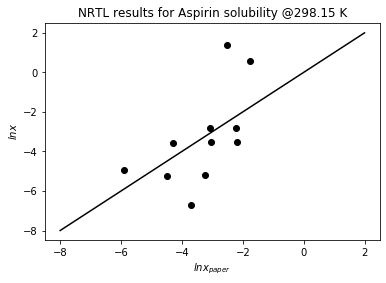

In [8]:
plt.title('NRTL results for Aspirin solubility @298.15 K')
plt.xlabel('$ln x_{paper}$')
plt.ylabel('$ln x$')
plt.plot(Table.ln_x_paper, Table.ln_x_NRTL, 'ok', ls='None')
plt.plot([-8, 2], [-8, 2], '-k')